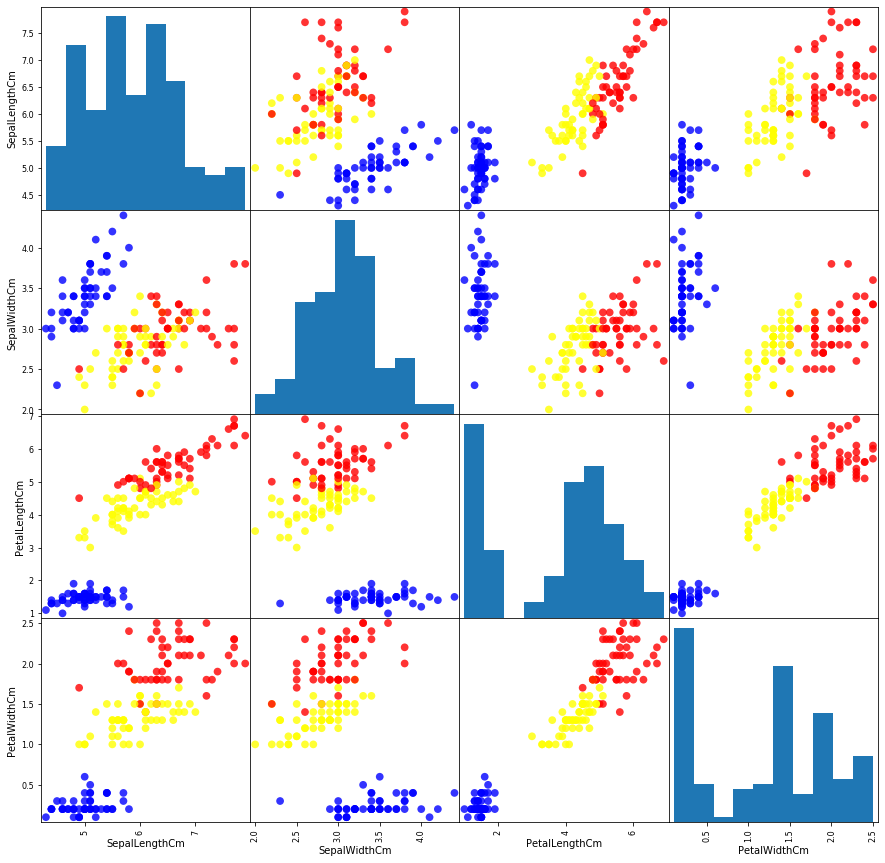

In [1]:
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing 
import math
import warnings

'''
My Own Algorithms Import
'''
from preprocessing.scaler import MinMaxScaler, StandardScaler
from preprocessing.pca import PCA
from supervisedLearningAlgorithms.knn import KNN
from analysis.confusion_matrix import ConfusionMatrix
from analysis.roc import ROC


#Ignore Warnings
warnings.filterwarnings("ignore")

#read data
iris_data = pd.read_csv('data-sets/iris.csv')

#randomize data with given seed
iris_data = iris_data.reindex(np.random.RandomState(seed=42).permutation(iris_data.index))
    
def assign_colors_to_iris(y_train):
    colors = []
    for row in y_train:
        assigned = "blue"
        if (row == "Iris-versicolor"):
            assigned = "yellow"
        elif(row == "Iris-virginica"):
            assigned = "red"
        colors.append(assigned)
    return colors
pd.plotting.scatter_matrix(iris_data[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]], marker='o', s=60, alpha=0.8, figsize=(15, 15), color=assign_colors_to_iris(iris_data['Species']))
plt.show()

## Analyze the Data

In [2]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 73 to 102
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB


In [3]:
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
73,74,6.1,2.8,4.7,1.2,Iris-versicolor
18,19,5.7,3.8,1.7,0.3,Iris-setosa
118,119,7.7,2.6,6.9,2.3,Iris-virginica
78,79,6.0,2.9,4.5,1.5,Iris-versicolor
76,77,6.8,2.8,4.8,1.4,Iris-versicolor


## Set up Data - remove all Iris-versicolor classifications

In [4]:
iris_data_2_classes = iris_data[iris_data['Species'] != 'Iris-versicolor']

In [5]:
seventy_five__percentile = int(len(iris_data_2_classes)*0.75) 
x_train, y_train = iris_data_2_classes.drop(['Species'], axis=1)[:seventy_five__percentile], iris_data_2_classes['Species'][:seventy_five__percentile]
x_test, y_test = iris_data_2_classes.drop(['Species'], axis=1)[seventy_five__percentile:], iris_data_2_classes['Species'][seventy_five__percentile:]
x_train.drop(["Id"], inplace=True, axis=1)
x_train.reset_index(drop=True, inplace=True)
x_test.drop(["Id"], inplace=True, axis=1)
x_test.reset_index(drop=True, inplace=True)

## Feature Scaling

In [6]:
x_train.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.7,3.8,1.7,0.3
1,7.7,2.6,6.9,2.3
2,5.4,3.4,1.5,0.4
3,6.9,3.1,5.1,2.3
4,6.5,3.2,5.1,2.0


Min Max Scaler

In [7]:
min_max_scaler = MinMaxScaler((0, 1))
x_train_min_max_scaled = min_max_scaler.fit_transform(x_train)
x_train_min_max_scaled.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,0.388889,0.727273,0.118644,0.083333
1,0.944444,0.181818,1.000000,0.916667
2,0.305556,0.545455,0.084746,0.125000
3,0.722222,0.409091,0.694915,0.916667
4,0.611111,0.454545,0.694915,0.791667


## Principal Component Analysis 2 Dimensions

No handles with labels found to put in legend.


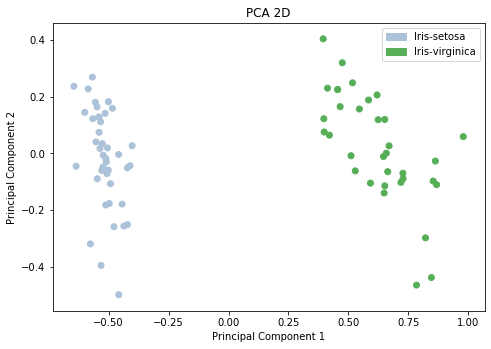

In [8]:
my_pca2 = PCA(2)
pca2_x_train_scaled = my_pca2.fit_transform(x_train_min_max_scaled)
my_pca2.plot("PCA 2D", y_train.values)

## Transform Test Dimensions

No handles with labels found to put in legend.


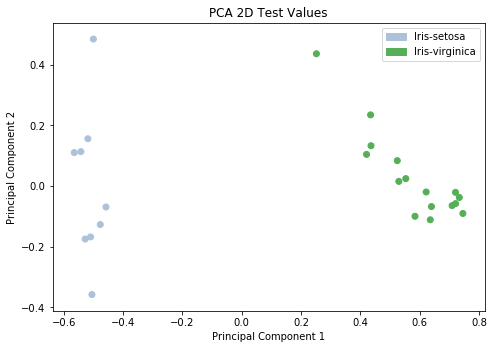

In [9]:
x_test_scaled = min_max_scaler.transform(x_test)
my_pca2.fit(x_train_min_max_scaled)
pca2_test_scaled = my_pca2.transform(x_test_scaled)
my_pca2.plot("PCA 2D Test Values", y_test.values)

# Support Vector Machine

In [10]:
import matplotlib.patches as mpatches
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())

def assign_colors_to_y(y_labeled, unique_labels):
    colors_dict = {}
    for i in range(len(unique_labels)):
        colors_dict[unique_labels[i]] = colors_list[i]
    y_color_labels = []
    for y in y_labeled:
        y_color_labels.append(colors_dict[y])
    return y_color_labels

In [11]:
from random import random, randint

class SVM:
    def fit(self, X, y, learning_rate = 0.01, regularization_parameter = 1/1000, iterations=1000):
        self.y_labels = y
        self.unique_labels = np.unique(y)
        if (len(self.unique_labels) != 2):
            print("This method is meant for only 2 classifications at the moment")
            return
        self.labels_dict = {-1: self.unique_labels[0], 1: self.unique_labels[1]}
        y = [-1 if label==self.unique_labels[0] else 1 for label in y]
        self.X = X
        self.y = y
        self.x_matrix = X.to_numpy()
        self.theta, self.b = self.gradient_descent(X, y, learning_rate, regularization_parameter, iterations)
        
    def gradient_descent(self, X, y, learning_rate, regularization_parameter, iterations):
        theta = np.array([0]*len(X.columns))
        b = 0
        X = X.to_numpy()
        size = len(X)
        for i in range(iterations):
            feature_index_random = int(random()*size)
            random_prediction = y[feature_index_random]
            feature_random = X[feature_index_random]
            hyperplane = np.dot(theta, feature_random)+b
            hyperplane_decision_factor = 1 - (random_prediction*hyperplane)
            #adjust b and theta
            if (hyperplane_decision_factor > 0):
                b = b + learning_rate*random_prediction
                theta = theta + 1/size*random_prediction*feature_random - 2*learning_rate*regularization_parameter*theta
            else:
                theta -= 2*learning_rate*regularization_parameter*theta
        return theta, b
    
    def predict(self, X):
        predictions = []
        X = X.to_numpy()
        for sample in X:
            prediction = np.dot(self.theta, sample)+self.b
            predictions.append(prediction)
        predictions_adjusted_to_int = [-1 if result < 0 else 1 for result in predictions]
        predictions_as_labels = [self.labels_dict[prediction] for prediction in predictions_adjusted_to_int]
        return predictions_as_labels
    
    def hyperplane_value(self, X, theta, b, value):
        return (-theta[0]*X-b+value) / theta[1]
    
    def plot(self, title = 'SVM Plot'):
        if (len(self.X.columns) != 2):
            print("cannot plot higher than 2 dimensions at the moment")
            return
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        max_vals_list = []
        min_vals_list = []
        for row in self.x_matrix:
            max_vals_list.append(max(row))
            min_vals_list.append(min(row))
        min_val = min(min_vals_list)
        max_val = max(max_vals_list)
        
        #set up colors
        y_color_labels = assign_colors_to_y(self.y_labels, self.unique_labels)
        #scatter data points
        ax.scatter(self.X[self.X.columns[0]], self.X[self.X.columns[1]], color = y_color_labels, 
               marker = "o")
        
        #plot positive support vector
        # (theta.x+b) = 1
        psv1 = self.hyperplane_value(min_val, self.theta, self.b, 1)
        psv2 = self.hyperplane_value(max_val, self.theta, self.b, 1)
        ax.plot([min_val,max_val],[psv1,psv2], 'black')
        
        #plot negative support vector
        # (w.x+b) = -1
        nsv1 = self.hyperplane_value(min_val, self.theta, self.b, -1)
        nsv2 = self.hyperplane_value(max_val, self.theta, self.b, -1)
        ax.plot([min_val,max_val],[nsv1,nsv2], 'black')
        
        #plot hyperplace
        hyp1 = self.hyperplane_value(min_val, self.theta, self.b, 0)
        hyp2 = self.hyperplane_value(max_val, self.theta, self.b, 0)
        ax.plot([min_val,max_val],[hyp1,hyp2], 'y--')
        
        #add labels and title
        ax.set_title(title)
        plt.legend(handles=[mpatches.Patch(color=colors_list[i], label=self.unique_labels[i]) for i in range(len(self.unique_labels))])

In [12]:
svm = SVM()
svm.fit(pca2_x_train_scaled, y_train.values)

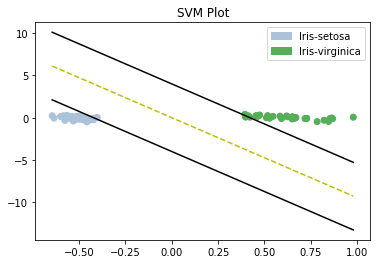

In [13]:
svm.plot()

In [14]:
predictions = svm.predict(pca2_test_scaled)

## Confusion Matrix

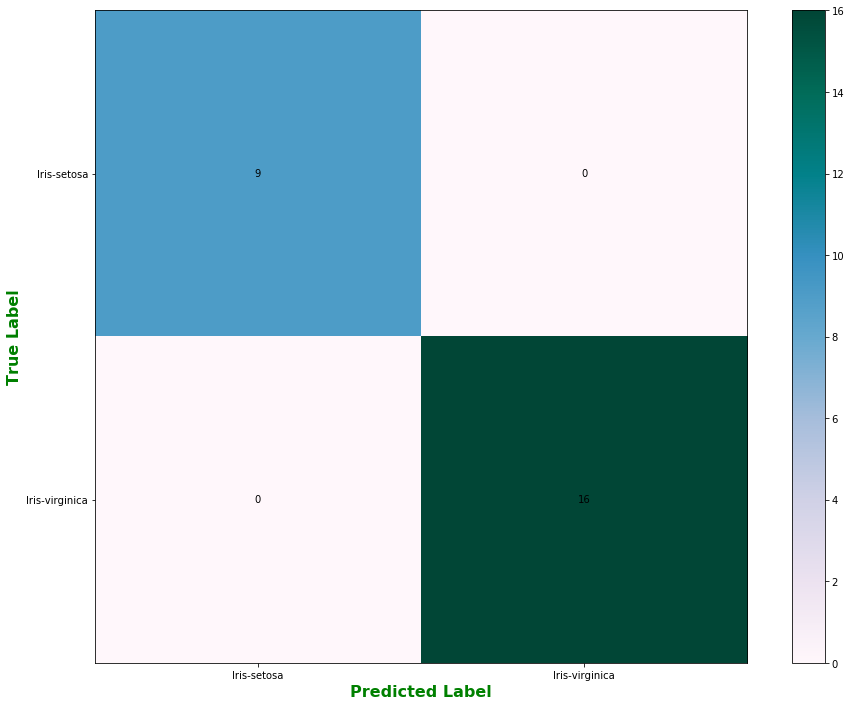

In [15]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(predictions, y_test.values)
confusion_matrix.plot()

In [16]:
confusion_matrix.measurements("Iris-setosa")

Confusion Matrix label measurements for  Iris-setosa
Accuracy rate 1.0
Error rate 0.0
Recall 1.0
False Positive Rate 0.0
True Negative Rate 0.0
Precision 1.0
Prevalence 0.36
Matthews Correlation Coefficient 1.0


## Compare with sklearn

In [17]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(pca2_x_train_scaled, y_train)
SVC(gamma='auto')
skpredictions2d = clf.predict(pca2_test_scaled)
skpredictions2d

array(['Iris-setosa', 'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica'], dtype=object)

## Confusion Matrix

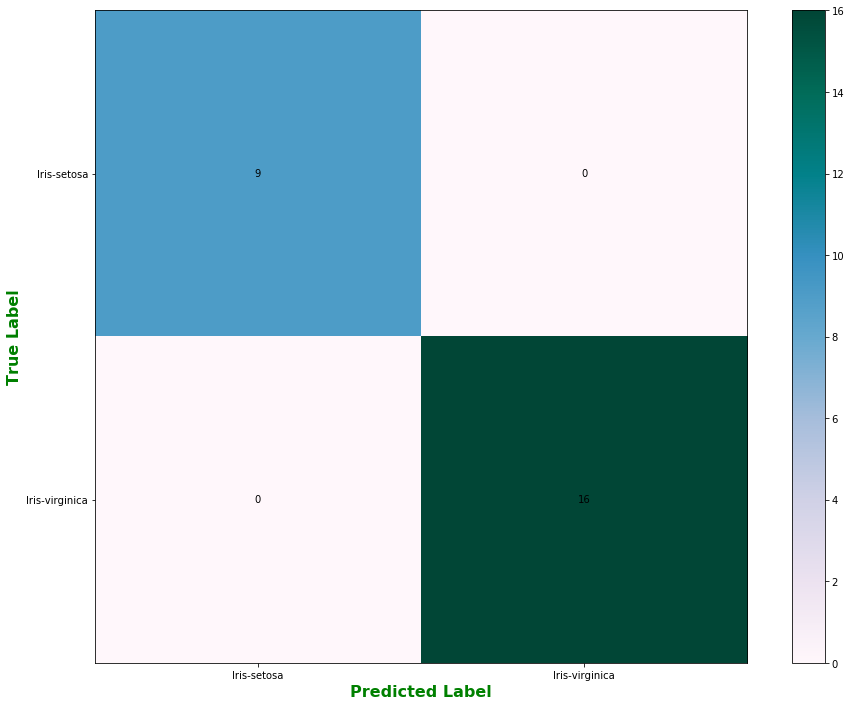

In [18]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(skpredictions2d, y_test.values)
confusion_matrix.plot()

In [19]:
confusion_matrix.measurements("Iris-setosa")

Confusion Matrix label measurements for  Iris-setosa
Accuracy rate 1.0
Error rate 0.0
Recall 1.0
False Positive Rate 0.0
True Negative Rate 0.0
Precision 1.0
Prevalence 0.36
Matthews Correlation Coefficient 1.0


## Non Linearly Separable Example - Instead Remove Iris Setosa

In [20]:
iris_data_2_classes = iris_data[iris_data['Species'] != 'Iris-setosa']

In [21]:
seventy_five__percentile = int(len(iris_data_2_classes)*0.75) 
x_train, y_train = iris_data_2_classes.drop(['Species'], axis=1)[:seventy_five__percentile], iris_data_2_classes['Species'][:seventy_five__percentile]
x_test, y_test = iris_data_2_classes.drop(['Species'], axis=1)[seventy_five__percentile:], iris_data_2_classes['Species'][seventy_five__percentile:]
x_train.drop(["Id"], inplace=True, axis=1)
x_train.reset_index(drop=True, inplace=True)
x_test.drop(["Id"], inplace=True, axis=1)
x_test.reset_index(drop=True, inplace=True)

## Feature Scaling

Min Max Scaler

In [22]:
min_max_scaler = MinMaxScaler((0, 1))
x_train_min_max_scaled = min_max_scaler.fit_transform(x_train)
x_train_min_max_scaled.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,0.379310,0.444444,0.435897,0.133333
1,0.931034,0.333333,1.000000,0.866667
2,0.344828,0.500000,0.384615,0.333333
3,0.620690,0.444444,0.461538,0.266667
4,0.206897,0.500000,0.153846,0.200000


## Principal Component Analysis 2 Dimensions

No handles with labels found to put in legend.


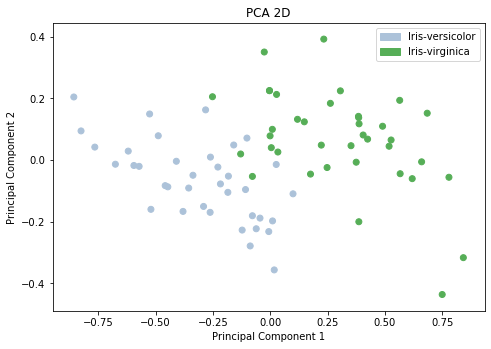

In [23]:
my_pca2 = PCA(2)
pca2_x_train_scaled = my_pca2.fit_transform(x_train_min_max_scaled)
my_pca2.plot("PCA 2D", y_train.values)

## Transform Test Dimensions

No handles with labels found to put in legend.


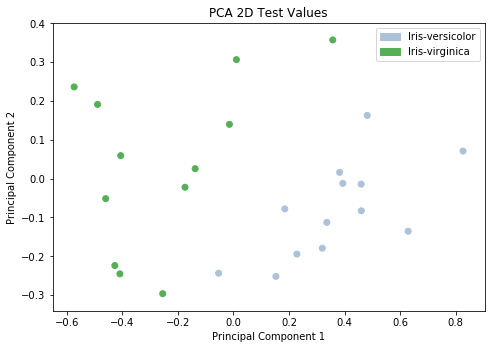

In [24]:
x_test_scaled = min_max_scaler.transform(x_test)
my_pca2.fit(x_train_min_max_scaled)
pca2_test_scaled = my_pca2.transform(x_test_scaled)
my_pca2.plot("PCA 2D Test Values", y_test.values)

In [25]:
svm = SVM()
svm.fit(pca2_x_train_scaled, y_train.values)

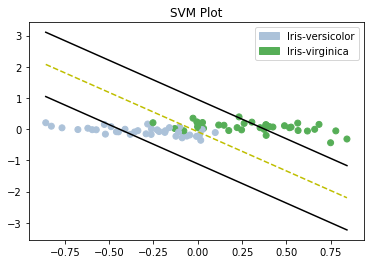

In [26]:
svm.plot()

In [27]:
predictions = svm.predict(pca2_test_scaled)

## Confusion Matrix

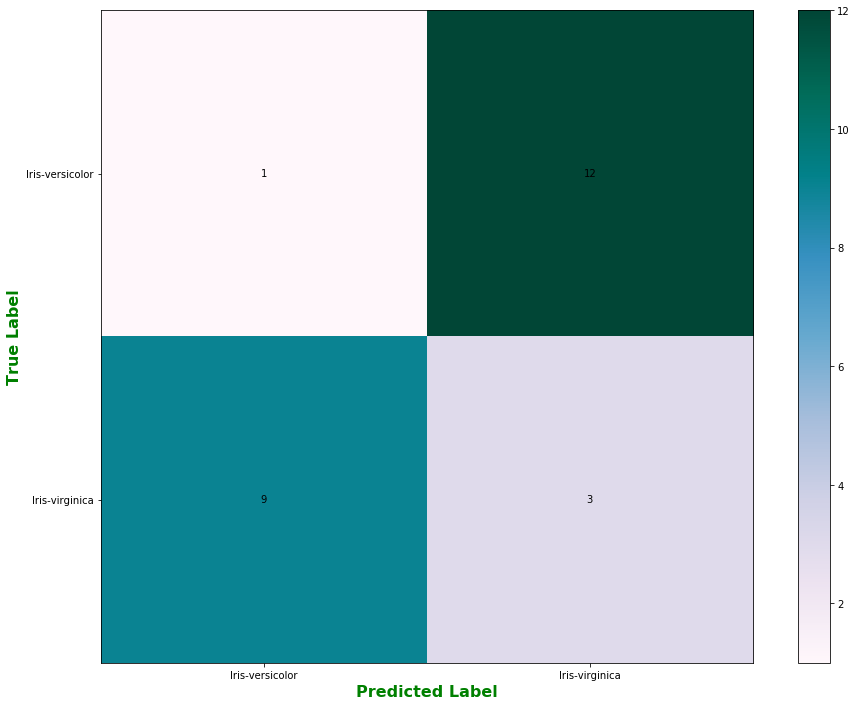

In [28]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(predictions, y_test.values)
confusion_matrix.plot()

In [29]:
confusion_matrix.measurements("Iris-virginica")

Confusion Matrix label measurements for  Iris-virginica
Accuracy rate 0.16
Error rate 0.84
Recall 0.25
False Positive Rate 0.9230769230769231
True Negative Rate 0.75
Precision 0.2
Prevalence 0.48
Matthews Correlation Coefficient -0.6864064729836441


## Compare with SKLearn

In [30]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(pca2_x_train_scaled, y_train)
SVC(gamma='auto')
skpredictions2d = clf.predict(pca2_test_scaled)
skpredictions2d

array(['Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-versicolor', 'Iris-virginica', 'Iris-virginica',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-virginica', 'Iris-versicolor', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-versicolor'], dtype=object)

## Confusion Matrix

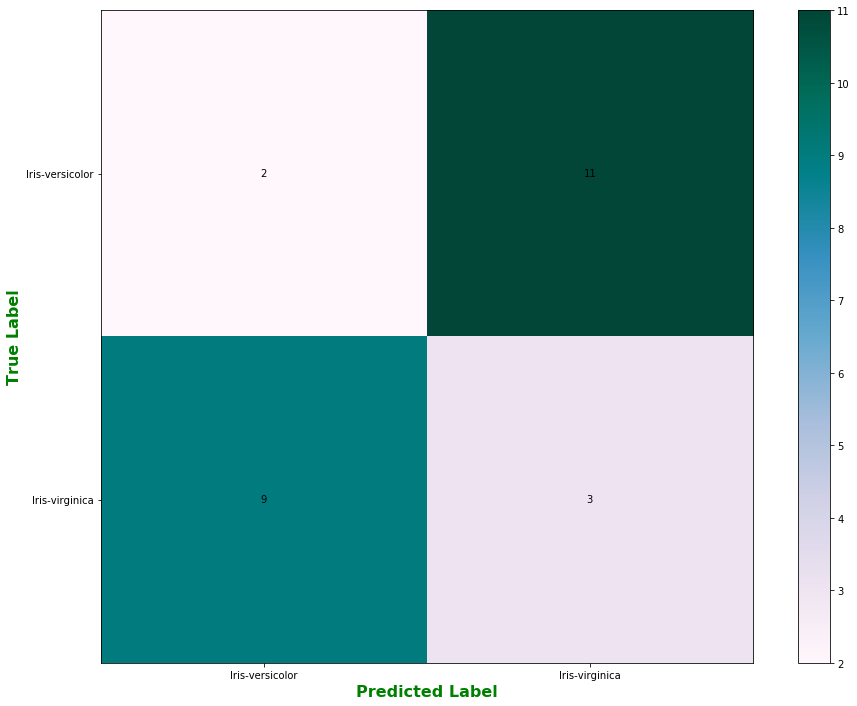

In [31]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(skpredictions2d, y_test.values)
confusion_matrix.plot()

# Applying Kernel Function

## Construct Data

In [32]:
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
colors_list = list(colors._colors_full_map.values())

def labelsToInt(labels):
        colors = ['r']
        n_labels = len(labels)
        id_result = [0 for i in range(n_labels)]
        id_count = 0
        id_dict = {}
        for i in range(n_labels):
            if labels[i] not in id_dict:
                id_dict[labels[i]] = id_count
                id_count+=1
            id_result[i] = colors_list[id_dict[labels[i]]]
        return id_result, [k for k in id_dict]
    
def plot(df, labels, title):
        res_color, labels = labelsToInt(labels)
        fig=plt.figure()
        n_components = len(df.columns)
        if (n_components == 2):
            ax=fig.add_axes([0,0,1,1])
            ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, c=res_color)
            ax.legend()
            ax.set_xlabel(df.columns[0])
            ax.set_ylabel(df.columns[1])
        elif (n_components == 3):
            ax = Axes3D(fig)
            ax.scatter(df[df.columns[0]], df[df.columns[1]], df[df.columns[2]],  c=res_color)
            ax.set_xlabel(df.columns[0])
            ax.set_ylabel(df.columns[1])
            ax.set_zlabel(df.columns[2])
        plt.legend(handles=[mpatches.Patch(color=colors_list[i], label=labels[i]) for i in range(len(labels))])
        ax.set_title(title)
        plt.show()

In [33]:
inner_x = [randint(-2, 2) for i in range(40)]
inner_y = [randint(-2, 2) for i in range(40)]
outer_x = [randint(-8, 12) for i in range(10)] + [randint(-12, -12) for i in range(10)] + [randint(8, 12) for i in range(10)] + [randint(-12, -8) for i in range(10)]
outer_y = [randint(10, 14) for i in range(10)] + [randint(-14, -10) for i in range(10)] + [randint(-14, 14) for i in range(10)] + [randint(-14, -14) for i in range(10)]
inner_labels = ['Inner']*40
outer_labels = ['Outer']*40

# combine columns
all_x = inner_x + outer_x
all_y = inner_y + outer_y
labels = inner_labels + outer_labels
sample_df = pd.DataFrame() 
sample_df['x'] = all_x
sample_df['y'] = all_y
sample_df['label'] = labels
sample_df.head()

,x,y,label
0,-2,-2,Inner
1,-1,2,Inner
2,-2,2,Inner
3,-1,0,Inner
4,-2,-1,Inner


No handles with labels found to put in legend.


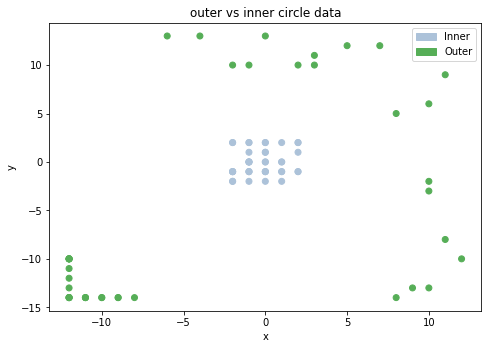

In [34]:
other_columns = sample_df.drop(['label'], axis=1)
plot(other_columns, sample_df['label'], "outer vs inner circle data")

## define function

In [35]:
def sample_function(x, y):
    return np.square(x) + np.square(y)

## Apply kernel trick

In [36]:
new_dimension = sample_function(sample_df['x'], sample_df['y'])
other_columns['z'] = new_dimension

## Plot new 3-D dataset

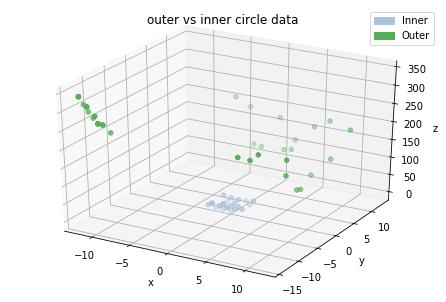

In [37]:
plot(other_columns, sample_df['label'], "outer vs inner circle data")

## Shuffle Data

In [38]:
sample_df = sample_df.reindex(np.random.RandomState(seed=42).permutation(sample_df.index))

In [39]:
seventy_five__percentile = int(len(sample_df)*0.75) 
x_train, y_train = sample_df.drop(['label'], axis=1)[:seventy_five__percentile], sample_df['label'][:seventy_five__percentile]
x_test, y_test = sample_df.drop(['label'], axis=1)[seventy_five__percentile:], sample_df['label'][seventy_five__percentile:]
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

In [40]:
svm = SVM()
svm.fit(x_train, y_train.values, learning_rate = 0.01, regularization_parameter = 1/8000)

In [41]:
predictions = svm.predict(x_test)

## Confusion Matrix

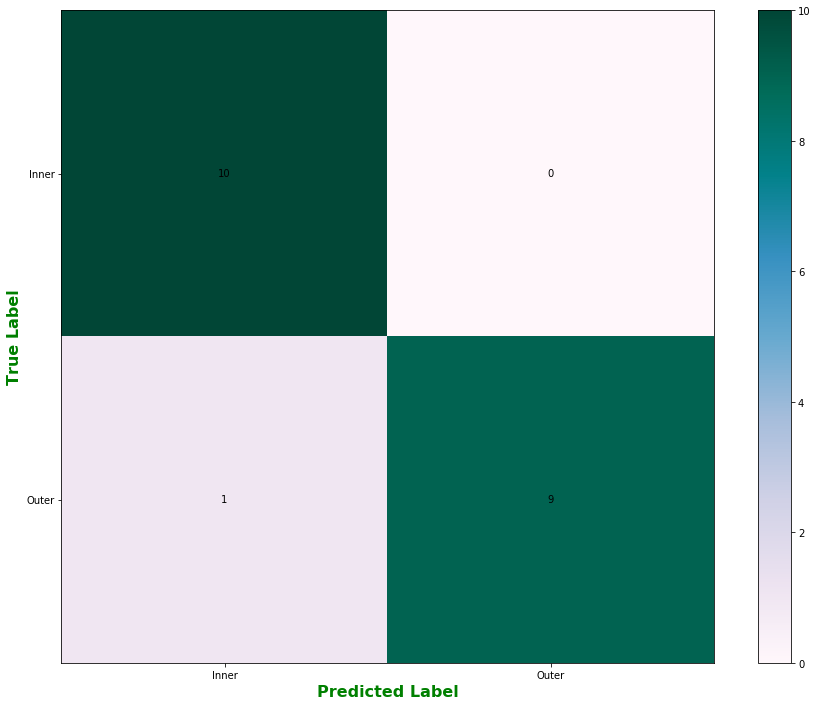

In [42]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(predictions, y_test.values)
confusion_matrix.plot()

In [43]:
confusion_matrix.measurements("Outer")

Confusion Matrix label measurements for  Outer
Accuracy rate 0.95
Error rate 0.050000000000000044
Recall 0.9
False Positive Rate 0.0
True Negative Rate 0.09999999999999998
Precision 1.0
Prevalence 0.5
Matthews Correlation Coefficient 0.9045340337332909
